In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
pd.set_option('display.max_rows', 50)
np.set_printoptions(threshold=50)
import joblib
from scipy.stats import fisher_exact
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib import cm
import statsmodels.api as sm
import pickle
from joblib import load

# Load analysis datasets

In [2]:
alldiag_pivot = pd.read_parquet('pivot_table_final.parquet')

# Dimentional Reduction

## (If necessary) Sampling from the dataset

In [3]:
alldiag_pivot_sp = alldiag_pivot

In [4]:
y = alldiag_pivot_sp["isAD"].replace({1:"Alzheimer", 0:"Control"})

In [5]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [6]:
z = alldiag_pivot_sp[demographic_cols]
X = alldiag_pivot_sp.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [7]:
X

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),*Unknown,1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture",...,Zenker diverticula,Zenker's hypopharyngeal diverticulum,Zonular dehiscence,Zoster iridocyclitis,Zoster vaccine,"Zygomatic fracture, left side, initial encounter for closed fracture (HCC)","Zygomatic fracture, unspecified side, initial encounter for open fracture (HCC)","Zygomatic fracture, unspecified side, subsequent encounter for fracture with routine healing",Zygomatic hyperplasia,Zygomycosis (phycomycosis or mucormycosis) (HCC)
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFE8107CDA348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF1B8ED4683F,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF226D09433C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA(n=1750)

In [8]:
pca = joblib.load('pca1750_model.joblib')
data_pca = np.load('data_pca1750_final.npy')

## Kmeans Clustering (n=2) & UMAP

In [9]:
# K-means Clustering(n =2)
kmeans2 = KMeans(n_clusters=2, random_state=42) 
kmeans2.fit(data_pca)
data_pca_kmeans2 = kmeans2.fit_transform(data_pca)

In [10]:
kmeans2_labels = kmeans2.labels_

In [11]:
'''
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True, verbose = 1)
X_embedded = mapper.fit_transform(data_pca)
'''

"\n%%time\nmapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True, verbose = 1)\nX_embedded = mapper.fit_transform(data_pca)\n"

In [12]:
with open('umap_results.pkl', 'rb') as file:
    X_embedded = pickle.load(file)

In [13]:
loaded_umap_model = load('umap_model.joblib')

Sat Mar  9 20:36:59 2024 Building and compiling search function


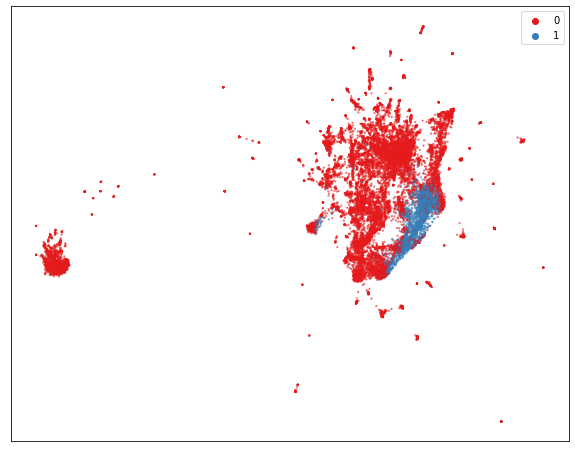

In [14]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = kmeans2.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## UMAP Visualization colored by AD

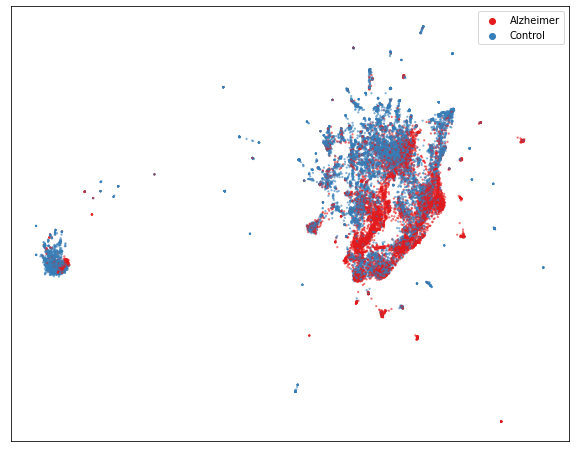

In [15]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    np.random.seed(0)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = y[reordered_indices].values, 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Kmeans Clustering (n=3) & UMAP

In [16]:
# K-means Clustering(n =3)
kmeans3 = KMeans(n_clusters=3, random_state=42) 
kmeans3.fit(data_pca)
data_pca_kmeans2 = kmeans3.fit_transform(data_pca)

In [17]:
kmeans3_labels = kmeans3.labels_

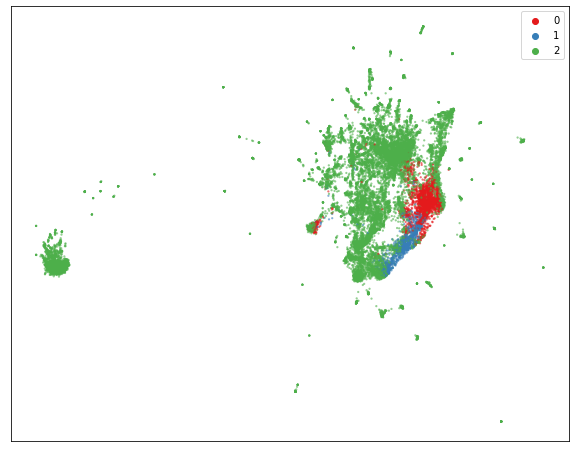

In [18]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = kmeans3.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Kmeans Clustering (n=4) & UMAP

In [19]:
# K-means Clustering(n =4)
kmeans4 = KMeans(n_clusters=4, random_state=42) 
kmeans4.fit(data_pca)
data_pca_kmeans4 = kmeans4.fit_transform(data_pca)

In [20]:
kmeans4_labels = kmeans4.labels_

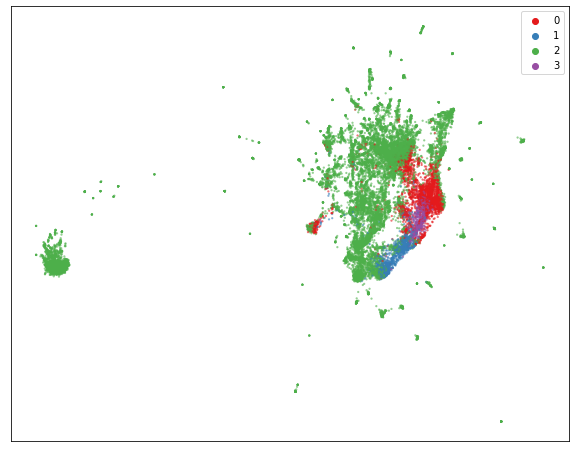

In [21]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = kmeans4.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')

## Kmeans Clustering (n=5) & UMAP

In [22]:
# K-means Clustering(n =5)
kmeans5 = KMeans(n_clusters=5, random_state=42) 
kmeans5.fit(data_pca)
data_pca_kmeans5 = kmeans5.fit_transform(data_pca)

In [23]:
kmeans5_labels = kmeans5.labels_

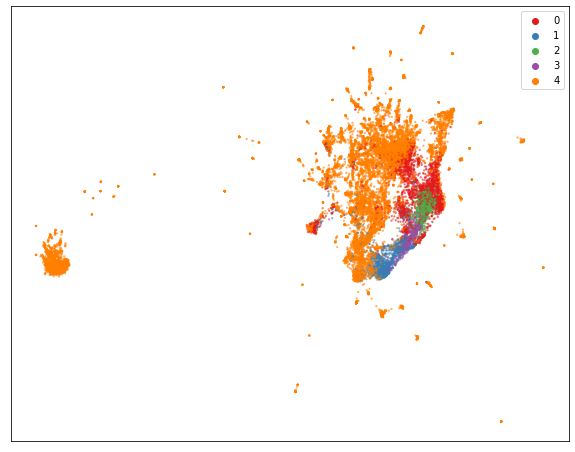

In [24]:
with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    
    np.random.seed(1)
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    
    sns.scatterplot(x = X_embedded[reordered_indices ,0], y = X_embedded[reordered_indices ,1], 
                    hue = kmeans5.labels_[reordered_indices], 
                    s=5, linewidth = .0, alpha = .6,
                    palette="Set1"
                   )
    ax = plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white')